In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping

### Read in the nutritional info metadata and define the columns. Select only those rows in the metadata for which there are images available. 

In [2]:
# Define file paths for metadata and imagery folders
metadata_folder = 'nutrition5k_dataset/metadata/'
imagery_folder = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Load metadata CSV files
metadata_cafe1 = pd.read_csv(os.path.join(metadata_folder, 'dish_metadata_cafe1.csv'), on_bad_lines='skip', header=None)
metadata_cafe2 = pd.read_csv(os.path.join(metadata_folder, 'dish_metadata_cafe2.csv'), on_bad_lines='skip', header=None)

# Combine both metadata files into one DataFrame
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)

# Display the first few rows to inspect the structure
display(metadata.head())

# Now, we know that the first column (column 0) is 'dish_id'
# Let's ensure it's a string, so we can match it to the image paths
metadata[0] = metadata[0].astype(str)

# Function to check if an image exists for a given dish_id.  Some dish_id have no associated imagery.
def image_exists(dish_id):
    image_path = os.path.join(imagery_folder, f'{dish_id}/rgb.png')
    return os.path.exists(image_path)

# Filter the metadata to retain only rows with a corresponding image
metadata_with_images = metadata[metadata[0].apply(image_exists)]

# Display the number of rows before and after filtering
display(f"Total rows in the metadata before filtering: {len(metadata)}")
display(f"Total rows in metadata after eliminating those without associated images: {len(metadata_with_images)}")
print("\n")

# Optionally, save the filtered metadata if needed
# metadata_with_images.to_csv('filtered_metadata.csv', index=False)

# Display the first few rows of the filtered metadata
print("First few rows of the combined metadata file, where there is a plate image corresponding to the dish_id.")
display(metadata_with_images.head())

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,0.000425,0.019754,0.004248,ingr_0000000513,millet,3.414345,4.063071,0.034143,0.80920,0.119502
1,dish_1562688426,137.569992,88.0,8.256000,5.190000,10.297000,ingr_0000000433,roasted potatoes,17.000000,23.970000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,0.000000,0.000000,0.000000,ingr_0000000524,parsley,0.752816,0.279295,0.006023,0.04818,0.021832
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Total rows in the metadata before filtering: 4583'

'Total rows in metadata after eliminating those without associated images: 3079'



First few rows of the combined metadata file, where there is a plate image corresponding to the dish_id.


,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,dish_1561662216,300.794281,193.0,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,0.000425,0.019754,0.004248,ingr_0000000513,millet,3.414345,4.063071,0.034143,0.80920,0.119502
2,dish_1561662054,419.438782,292.0,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,0.000000,0.000000,0.000000,ingr_0000000524,parsley,0.752816,0.279295,0.006023,0.04818,0.021832
3,dish_1562008979,382.936646,290.0,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dish_1560455030,20.590000,103.0,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,dish_1558372433,74.360001,143.0,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Obtain each image from the dataset folder, resize, normalize. OHE encode the image labels.

In [3]:
# Set folder path for images
image_folder = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Image size for resizing
image_size = (224, 224)

# Lists to store images and labels
images = []
dish_ids = []

# Loop through each row in the metadata
for index, row in metadata.iterrows():
    # Since 'dish_id' is in the first column (column 0), we use row[0] instead of row['dish_id']
    dish_id = row[0]  # Accessing the first column of the row (which contains 'dish_id')
    
    # Construct the image path
    image_path = os.path.join(image_folder, dish_id, 'rgb.png')
    
    # Check if the image exists
    if os.path.exists(image_path):
        # Load the image
        image = cv2.imread(image_path)
        
        # Resize the image to a consistent size
        image = cv2.resize(image, image_size)
        
        # Convert the image to an array
        image = img_to_array(image)
        
        # Append the image and dish_id to the respective lists
        images.append(image)
        dish_ids.append(dish_id)

# Convert the lists to numpy arrays
images = np.array(images, dtype="float32") / 255.0  # Normalize pixel values to [0, 1]
dish_ids = np.array(dish_ids)

# Convert dish_ids to categorical labels
dish_id_labels = pd.Categorical(dish_ids).codes  # Convert dish_ids to numerical labels
dish_id_labels = to_categorical(dish_id_labels)  # One-hot encode the labels
num_dishes = dish_id_labels.shape[1]             # Determine the number of ingredients in each row

# Print the shapes of the resulting arrays
print(f"Images shape: {images.shape}")
print(f"Dish ID labels shape: {dish_id_labels.shape}")

Images shape: (3079, 224, 224, 3)
Dish ID labels shape: (3079, 3079)


### Train-test split.

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, dish_id_labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2463, 224, 224, 3)
(2463, 3079)
(616, 224, 224, 3)
(616, 3079)


### Model definition. Use data augmentation, Import base_model and set freezing layer. Customize Dense layers. Print number of model layers.

In [8]:
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import hard_silu
from tensorflow.keras.regularizers import l1
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Create an instance of ImageDataGenerator with augmentation.  Preprocess X_train for MobileNetV3.
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=128)  # Set batch size

#Pre-process the X_test data, too. 
X_test = preprocess_input(X_test)

# Load pre-trained model without the top layer
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Set the number of layers for which the ImageNet weights will be preserved:
freeze_layer = 12
for layer in base_model.layers[:freeze_layer]:
    layer.trainable = False

# Set the rest of the layers to be fine-tuned on the training set.
for layer in base_model.layers[freeze_layer:]:
    layer.trainable = True

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(4096, activation='relu', kernel_regularizer=l1(1e-4), kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu', kernel_regularizer=l1(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', kernel_regularizer=l1(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l1(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l1(1e-4))(x)
x = Dropout(0.3)(x)
x = Dense(num_dishes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
print(f"The model has {len(model.layers)} layers total, of which {len(base_model.layers)} comes from the base_model.")

The model has 203 layers total, of which 187 comes from the base_model.


### Set optimizer, LR, loss and metrics hyperparameters. 

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import TopKCategoricalAccuracy

early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='accuracy', patience=31, factor=0.8)

# Compile and train the model. Don't just use the top pick to calculate accuracy, but whether the correct pick was in the top 5.
optimizer = SGD(learning_rate=0.01, nesterov=True)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')])

### Train the model.

In [10]:
history = model.fit(train_generator, validation_data=(X_test, y_test), epochs=200, callbacks=[early_stop, lr_reduction])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 4.7629e-04 - loss: 42.8429 - top_5_categorical_accuracy: 0.0028 - val_accuracy: 0.0000e+00 - val_loss: 42.7137 - val_top_5_categorical_accuracy: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.0000e+00 - loss: 42.7938 - top_5_categorical_accuracy: 6.4755e-04 - val_accuracy: 0.0016 - val_loss: 42.6841 - val_top_5_categorical_accuracy: 0.0016 - learning_rate: 0.0100
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 2.3586e-04 - loss: 42.7764 - top_5_categorical_accuracy: 0.0014 - val_accuracy: 0.0000e+00 - val_loss: 42.6566 - val_top_5_categorical_accuracy: 0.0016 - learning_rate: 0.0100
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 3.8668e-05 - loss: 42.7384 - top_5_categorical_accuracy: 0.0012 - val_accuracy: 0.0000e+00 - val_loss: 42.6308 - val_top_5_categorical_accuracy: 0.0016 - learning_rate: 0.0100
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 5

In [11]:
# Save the trained Keras model
model.save('n5k_model.h5')

In [ ]:
# Load the last saved model
model = tf.keras.models.load_model('n5k_model.h5')

### Plot training and validation accuracy and loss.

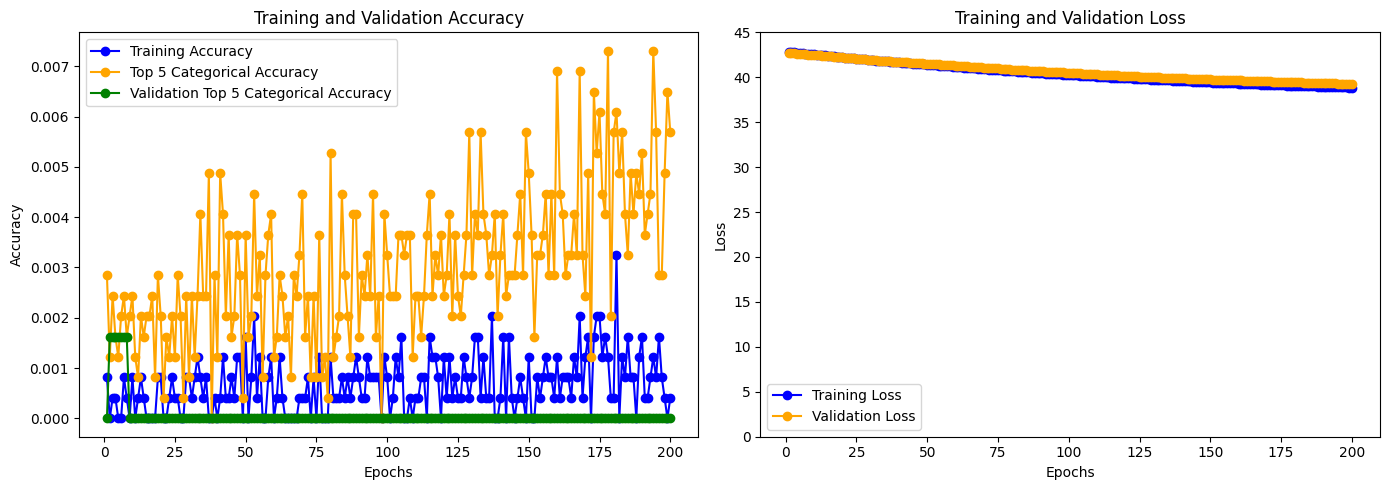

In [12]:
# Get training and validation accuracy/loss from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top5_acc = history.history['top_5_categorical_accuracy']
val_top5_acc = history.history['val_top_5_categorical_accuracy']

# Get number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy and loss side-by-side
plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')  # Blue for training accuracy
plt.plot(epochs, train_top5_acc, 'o-', color='orange', label='Top 5 Categorical Accuracy')  # Orange for validation accuracy
plt.plot(epochs, val_top5_acc, 'o-', color='green', label='Validation Top 5 Categorical Accuracy')  # Green for top_K_validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.ylim(0,45)
plt.plot(epochs, loss, 'bo-', label='Training Loss')  # Blue for training loss
plt.plot(epochs, val_loss, 'o-', color='orange', label='Validation Loss')  # Orange for validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Automatically adjust layout to fit everything
plt.tight_layout()

# Show the plots
plt.show()

### Define functions to get glycemic index data from glycemic_index.xlsx; from the prediction, get nutritional info; display nutritional information.

In [13]:
import cv2

# Load the glycemic index data from the Excel file
gi_data = pd.read_excel("glycemic_index.xlsx")

# Create a dictionary from the Excel file for quick lookup
gi_dict = pd.Series(gi_data['Glycemic index'].values, index=gi_data['Item']).to_dict()

# Function to get glycemic index from the Excel data
def get_glycemic_index(ingredient):
    # Normalize ingredient names for case-insensitive matching
    ingredient_lower = ingredient.lower()
    gi_dict_lower = {k.lower(): v for k, v in gi_dict.items()}

    # Return the glycemic index if present in the Excel data
    if ingredient_lower in gi_dict_lower:
        return gi_dict_lower[ingredient_lower]
    else:
        return "GI not available"

# Predict dish_id from an image
def predict_dish(image):
    image = cv2.resize(image, image_size)  # Resize to match the input shape
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.astype("float32") / 255.0  # Normalize

    # Predict dish ID
    prediction = model.predict(image)
    dish_index = np.argmax(prediction)  # Get the predicted dish index
    predicted_dish_id = pd.Categorical(dish_ids).categories[dish_index]
    
    # Retrieve nutritional info based on predicted dish_id
    nutrition_info = metadata[metadata[0] == predicted_dish_id]

    if nutrition_info.empty:
        return predicted_dish_id, None  # Return None if no matching dish_id is found
    return predicted_dish_id, nutrition_info.iloc[0]
    
# Function to calculate the weighted glycemic index for the entire dish
def calculate_weighted_gi_and_gl(ingredients_info):
    total_weight = 0  # Sum of all ingredient masses
    weighted_sum_gi = 0  # To accumulate the weighted sum of GIs
    total_glycemic_load = 0  # To accumulate the total glycemic load

    # Loop through each ingredient information tuple (ID, Name, Mass, Calories, Fat, Carbs, Protein)
    for ingredient_info in ingredients_info:
        ingredient_name = ingredient_info[1]
        ingredient_mass = ingredient_info[2]
        ingredient_carbs = ingredient_info[5]  # Carbohydrates in grams
        
        # Get the glycemic index for the ingredient
        gi_value = get_glycemic_index(ingredient_name)
        
        # If GI is available and valid, add to the weighted sum
        if isinstance(gi_value, (int, float)) and ingredient_carbs > 0:
            weighted_sum_gi += gi_value * ingredient_mass
            total_weight += ingredient_mass
            
            # Calculate Glycemic Load (GL) for the ingredient
            glycemic_load = (gi_value * ingredient_carbs) / 100
            total_glycemic_load += glycemic_load
        else:
            print(f"Warning: {gi_value} for {ingredient_name}")

    # Calculate the weighted average GI
    if total_weight > 0:
        weighted_avg_gi = weighted_sum_gi / total_weight
    else:
        weighted_avg_gi = "Total weight is zero, cannot calculate weighted average."

    return weighted_avg_gi, total_glycemic_load

# Calculate GI for the entire dish and calculate the GL
def display_nutrition_info(nutrition_info):

    column_names = [
        'Dish ID', 'Total Calories', 'Total Mass', 'Total Fat', 'Total Carbohydrates', 'Total Protein'
    ]
    
    # Display basic nutritional info
    print("=== Dish Nutritional Information ===")
    for i, column in enumerate(column_names):
        print(f"{column}: {nutrition_info[i]}")

    # Display ingredients and their nutritional info
    print("\n=== Ingredients Information ===")
    ingredient_offset = 6  # Ingredients start from the 7th column (index 6)
    ingredient_number = 1
    ingredients_info = []  # To store ingredient information for GI and GL calculation

    while ingredient_offset < len(nutrition_info):
        # Check if the ingredient name is NaN, which indicates no more ingredients
        if pd.isna(nutrition_info[ingredient_offset + 1]):
            break
        
        # Extract ingredient information
        ingredient_id = nutrition_info[ingredient_offset]
        ingredient_name = nutrition_info[ingredient_offset + 1]
        ingredient_mass = nutrition_info[ingredient_offset + 2]
        ingredient_calories = nutrition_info[ingredient_offset + 3]
        ingredient_fat = nutrition_info[ingredient_offset + 4]
        ingredient_carbs = nutrition_info[ingredient_offset + 5]
        ingredient_protein = nutrition_info[ingredient_offset + 6]

        print(f"\nIngredient {ingredient_number}:")
        print(f"  Ingredient ID: {ingredient_id}")
        print(f"  Ingredient Name: {ingredient_name}")
        print(f"  Ingredient Grams: {ingredient_mass}")
        print(f"  Ingredient Calories: {ingredient_calories}")
        print(f"  Ingredient Fat: {ingredient_fat}")
        print(f"  Ingredient Carbohydrates: {ingredient_carbs}")
        print(f"  Ingredient Protein: {ingredient_protein}")

        # Get the glycemic index for this ingredient
        gi_value = get_glycemic_index(ingredient_name)
        print(f"  Glycemic Index: {gi_value}")

        # Store ingredient info for weighted GI and GL calculation
        ingredients_info.append((
            ingredient_id, ingredient_name, ingredient_mass, ingredient_calories, ingredient_fat, ingredient_carbs, ingredient_protein
        ))

        # Move to the next ingredient (each ingredient has 7 columns)
        ingredient_offset += 7
        ingredient_number += 1

    # Calculate and display the weighted average glycemic index (GI) and total glycemic load (GL)
    weighted_avg_gi, total_glycemic_load = calculate_weighted_gi_and_gl(ingredients_info)
    print(f"\nThe Weighted Average Glycemic Index for the dish is: {weighted_avg_gi}")
    print(f"The Total Glycemic Load for the dish is: {total_glycemic_load:.2f}")

# Main function to process an image and predict the nutritional info
def process_dish_image(img_path):
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    
    # Plot the image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6)) 
    plt.imshow(img_rgb)
    plt.title("Plate of food to be predicted on")  
    plt.axis('off')  
    plt.show()

    # Predict the dish ID and nutrition info using the model
    dish_id, nutrition_info = predict_dish(img)  # Ensure this function is already implemented

    # Output the predicted dish ID
    print(f"Predicted Dish ID: {dish_id}")
    
    # Display the nutritional information and calculate GI and GL
    display_nutrition_info(nutrition_info)


In [14]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


### Select a test image of a dish to predict on, using the dropdown selector. 

In [20]:
import os
from ipywidgets import Dropdown, VBox, Button, Output, Layout
from IPython.display import display
from PIL import Image

# Path to the folder containing the images
image_folder = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Recursively find all 'rgb.png' files in subdirectories
image_files = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file == 'rgb.png':  # Only include 'rgb.png' files
            # Get the relative path of the image file
            image_files.append(os.path.join(root, file))

# Check if any 'rgb.png' files were found
if not image_files:
    print("No 'rgb.png' files found in the folder.")
else:
    # Create a dropdown widget with 'rgb.png' file options
    dropdown = Dropdown(
        options=image_files,
        description='Select Image to predict on:',
        layout=Layout(width='800px'),  # Set the width of the dropdown box
        style={'description_width': '200px'},  # Adjust the width of the label
        disabled=False,
    )

    # Create a button to load the selected image
    load_button = Button(description="Load Image")

    # Create an output widget to display the selected image
    output = Output()

    # Initial global variable (to store the selected image path) to None
    img_path = None

    # Function to load and display the selected image and store the path in img_path
    def load_image(b):
        global img_path
        with output:
            output.clear_output()  # Clear previous output
            img_path = dropdown.value  # Save the selected image's path
            print(f"Selected image path: {img_path}")  # Print the path for verification
            img = Image.open(img_path)
            process_dish_image(img_path)

    # Attach the load_image function to the button's click event
    load_button.on_click(load_image)

    # Display the widgets
    display(VBox([dropdown, load_button, output]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

### This code was just used to print all the ingredients in the dataset.  Ignore.

In [ ]:
# Initialize a set to store unique ingredient names (to avoid duplicates)
unique_ingredients = set()

# Ingredients start at column 7 (ingredient 1 name), and each ingredient block has 7 columns
ingredient_name_col_start = 7
num_columns = metadata.shape[1]  # Number of columns in the metadata

# Loop over each row in the existing metadata DataFrame
for _, row in metadata.iterrows():
    # Iterate through the ingredient columns, stepping by 7 columns (each ingredient block)
    for col in range(ingredient_name_col_start, num_columns, 7):
        ingredient_name = row[col]  # This is the ingredient name

        # Check if the ingredient name is valid (not NaN or empty)
        if pd.notna(ingredient_name) and ingredient_name != '':
            unique_ingredients.add(ingredient_name)

# Convert the set to a sorted list for better readability
sorted_ingredients = sorted(unique_ingredients)

# Print all the unique ingredients
print("List of unique ingredients in the metadata:")
for ingredient in sorted_ingredients:
   print(ingredient)